In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.datasets import MNIST
import torch.nn as nn
import numpy as np

In [2]:
X = torch.tensor([
  [1, 2, 3],
  [4, 5, 6],
  [7, 8, 9],
  [6, 3, 9]
])

A = torch.tensor([
  [
    [1, 0, 2],
    [3, 2, 0],
    [0, 0, 1]
  ],
  [
    [4, 2, 1],
    [0, 0, 9],
    [5, 2, 8]
  ]
])


print(A.shape)

out = torch.einsum("bf,oaf->bo", X, A)
print(out.shape)
print(out)

torch.Size([2, 3, 3])
torch.Size([4, 2])
tensor([[ 17,  71],
        [ 44, 164],
        [ 71, 257],
        [ 57, 228]])


In [3]:
torch.randn(10)

tensor([-0.2476, -0.6984,  0.5083,  0.3358, -1.2708,  0.3794,  1.1045, -0.9593,
         1.3050,  0.9328])

In [49]:
out = X@A
out.shape

torch.Size([2, 4, 3])

In [82]:
X = torch.tensor([1, 2, 3])
A = torch.tensor([
  [1, 0, 2],
  [3, 2, 0],
  [0, 0, 1]
])

torch.einsum("i,kl->k", X, A)

tensor([18, 30,  6])

In [35]:
class Quadratic(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_features, out_features))
        self.V = nn.Parameter(torch.randn(in_features, out_features))
        self.a = nn.Parameter(torch.randn(out_features))
        self.b = nn.Parameter(torch.randn(out_features))
        self.c = nn.Parameter(torch.randn(out_features))

    def forward(self, X):
        return (X @ self.W + self.a) * (X @ self.V + self.b) + self.c
        # With ReLU (2 epochs): 78% accuracy
        # Without ReLU (2 epochs): 84% accuracy
        # Linear baseline with ReLU (2 epochs): 95% accuracy
        # Linear without relu: 91% accuracy
        

        #return torch.exp(torch.log(X @ self.W.exp() + self.a.exp()) + torch.log(X @ self.V.exp()) + self.b.exp()) + self.c

        # Does not work very well.
        #return torch.exp(torch.log(X @ self.W.exp() + self.a.exp()) + torch.log(X @ self.V.exp()) + self.b.exp()) + self.c
        
        # Works alright
        # return ((X @ self.W + self.a) * X) @ self.V + self.b 

        """
        x1 + x2 + x3 + x1 x1 + x1 x2 + x1 x3 + x2 x2 + x2 x3 + 

        [x1, x2, x3] * [x1, x2, x3] = x1*x1 + x2*x2 + x3*x3

                        1 0 0              
        x1, x2, x3 @    0 1 0     =   x1 x2 x3, 
                        0 0 1
        """
        



In [153]:
test = Quadratic(2, 10)
X = torch.rand(2)
print(X)
Y = test.forward(X)
print(Y)

tensor([0.1019, 0.5213])
tensor([-0.5282,  1.1606,  0.7398,  0.4755, -0.4698,  0.5464, -0.7789, -0.0791,
        -0.4000,  0.4158], grad_fn=<AddBackward0>)


In [129]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, input):
        return (input @ self.weight) + self.bias

In [5]:
train_dataset = MNIST("data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST("data", train=False, download=True, transform=transforms.ToTensor())
train_data = DataLoader(
  dataset=train_dataset,
  batch_size=32,
)

In [17]:
x = torch.linspace(-1, 1, 1000)
y = torch.linspace(-1, 1, 1000)

In [18]:
z = x**2 + 0.3 + x + 0.5 * x *y + 0.1 * y**2 + 5

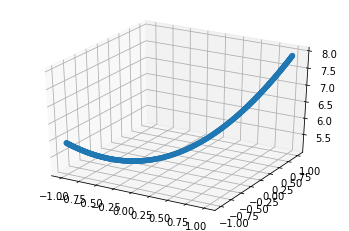

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z)

Training epoch 1.


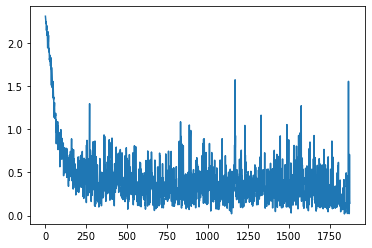

Training epoch 2.


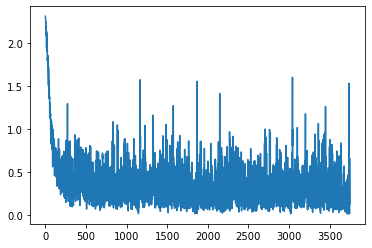

In [42]:
quadratic_model = nn.Sequential(
  Quadratic(28 * 28, 512),
  #nn.ReLU(),
  Quadratic(512, 128),
  #nn.ReLU(),
  nn.Linear(128, 10)
)

linear_model = nn.Sequential(
  nn.Linear(28 * 28, 512 * 2),
  nn.ReLU(),
  nn.Linear(512 * 2 , 128 * 2),
  nn.ReLU(),
  nn.Linear(128 * 2, 10)
)

model = linear_model
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criteria = nn.CrossEntropyLoss()

loss_history = []

num_epochs = 2
for epoch in range(1, num_epochs + 1):
    print(f"Training epoch {epoch}.")
  
    #tqdm_train_data = tqdm(train_data)
    for (images, labels) in train_data:
        images = images.reshape(-1, 28 * 28)
        optimizer.zero_grad()
        pred = model(images)

        #print(pred.shape, pred)

        #raise Exception("Hello world")
        loss = criteria(pred, labels)
        
        #print(loss.item())

        loss.backward()
        #print(loss.item())
        loss_history.append(loss.item())
        #tqdm_train_data.set_description(f"Loss: {loss.item()}")

        optimizer.step()

    plt.plot(loss_history)
    plt.show()

In [43]:
num_correct = 0

for (image, label) in test_dataset:
  pred = model(image.reshape(1, 28 * 28))
  pred_label = F.log_softmax(pred, dim=-1).argmax().item()
  if pred_label == label:
    num_correct += 1

print(f"Accuracy: {num_correct / len(test_dataset) * 100}%")

Accuracy: 91.12%
